In [204]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import seaborn as sns
sns.set(style="ticks", color_codes=True)

import chardet
import codecs

from sklearn.preprocessing import scale
import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf

import folium
from folium import plugins
from scipy import stats

%matplotlib inline
plt.style.use('seaborn-white')

In [205]:
delay = pd.read_csv('/Users/mille/Desktop/Supervised learning potpourri/DelayedFlights.csv', low_memory=False)
print('Dataframe dimensions:', delay.shape)


# providing more information per column on data types and number of null values
tab_info=pd.DataFrame(delay.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(delay.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(delay.isnull().sum()/delay.shape[0]*100)
                         .T.rename(index={0:'null values (%)'}))
tab_info


#

Dataframe dimensions: (1048575, 30)


,Unnamed: 0,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
column type,int64,int64,int64,int64,int64,int64,int64,float64,int64,object,int64,object,float64,float64,float64,float64,int64,object,object,int64,float64,int64,int64,object,int64,float64,float64,float64,float64,float64
null values (nb),0,0,0,0,0,0,0,3896,0,0,0,4,3896,157,3896,3896,0,0,0,0,3896,0,0,0,0,362841,362841,362841,362841,362841
null values (%),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,35,35,35,35,35


In [206]:
362841/1048575

0.34603247264144193

## **Imbalanced data**

The following variables: CarrierDelay, WeatherDelay, NASDelay, SecurityDelay, LateAircraftDelay

Contain **362841**  null values or **35%** of the entire data set. This is problematic and needs to be cleaned in order to make predictions within the data set. 

In [207]:
delay.head(3)

,Unnamed: 0,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,0,2008,1,3,4,2003,1955,2211,2225,WN,335,N712SW,128,150,116,-14,8,IAD,TPA,810,4,8,0,N,0,nan,nan,nan,nan,nan
1,1,2008,1,3,4,754,735,1002,1000,WN,3231,N772SW,128,145,113,2,19,IAD,TPA,810,5,10,0,N,0,nan,nan,nan,nan,nan
2,2,2008,1,3,4,628,620,804,750,WN,448,N428WN,96,90,76,14,8,IND,BWI,515,3,17,0,N,0,nan,nan,nan,nan,nan


# **Data prep**

**Background on the data**

https://www.kaggle.com/giovamata/airlinedelaycauses

The U.S. Department of Transportation's (DOT) Bureau of Transportation Statistics (BTS) tracks the on-time performance of domestic flights operated by large air carriers. Summary information on the number of on-time, delayed, canceled and diverted flights appears in DOT's monthly Air Travel Consumer Report, published about 30 days after the month's end, as well as in summary tables posted on this website. BTS began collecting details on the causes of flight delays in June 2003. Summary statistics and raw data are made available to the public at the time the Air Travel Consumer Report is released.

This version of the dataset was compiled from the Statistical Computing Statistical Graphics 2009 Data Expo and is also available here.

In [208]:
delay = delay[delay['Month'] == 1]


In [209]:
delay['Day'] = delay['DayofMonth']

In [210]:
delay.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183527 entries, 0 to 183526
Data columns (total 31 columns):
Unnamed: 0           183527 non-null int64
Year                 183527 non-null int64
Month                183527 non-null int64
DayofMonth           183527 non-null int64
DayOfWeek            183527 non-null int64
DepTime              183527 non-null int64
CRSDepTime           183527 non-null int64
ArrTime              182915 non-null float64
CRSArrTime           183527 non-null int64
UniqueCarrier        183527 non-null object
FlightNum            183527 non-null int64
TailNum              183527 non-null object
ActualElapsedTime    182915 non-null float64
CRSElapsedTime       183492 non-null float64
AirTime              182915 non-null float64
ArrDelay             182915 non-null float64
DepDelay             183527 non-null int64
Origin               183527 non-null object
Dest                 183527 non-null object
Distance             183527 non-null int64
TaxiIn         

#dropping columns

delay.drop(['Distance', 'Year', 'Unnamed: 0', 'AirTime', 'DayOfWeek', 
           'TaxiIn', 'TaxiOut', 'Month', 'DayofMonth', 'Day', 'UniqueCarrier', 'FlightNum',
           'TailNum', 'Origin', 'Dest'], axis = 1, inplace = True)
print(delay.shape)
delay.head()

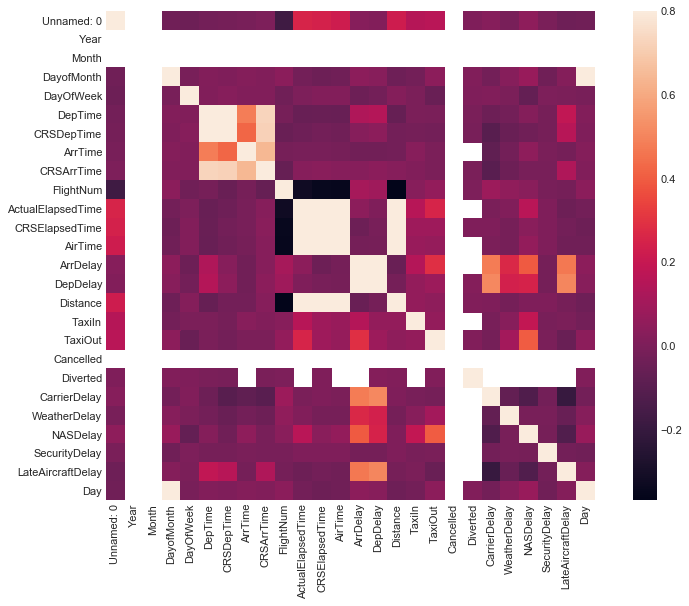

In [211]:
corrmat = delay.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);
plt.show()

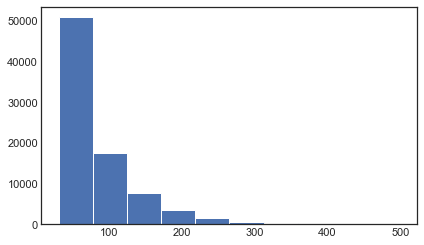

In [212]:
plt.hist(delay.ArrDelay, range= [30, 500])
plt.show()

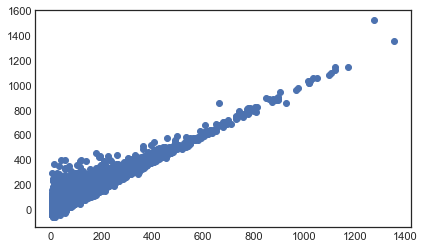

In [213]:
plt.scatter(delay.DepDelay,delay.ArrDelay)
plt.show()

#linear model - likely will model with linear regression 

Checking for missing values or nulls 

In [214]:

print(delay.shape)
delay.apply(lambda x: sum(x.isnull()),axis=0)

(183527, 31)


Unnamed: 0               0
Year                     0
Month                    0
DayofMonth               0
DayOfWeek                0
DepTime                  0
CRSDepTime               0
ArrTime                612
CRSArrTime               0
UniqueCarrier            0
FlightNum                0
TailNum                  0
ActualElapsedTime      612
CRSElapsedTime          35
AirTime                612
ArrDelay               612
DepDelay                 0
Origin                   0
Dest                     0
Distance                 0
TaxiIn                 612
TaxiOut                  0
Cancelled                0
CancellationCode         0
Diverted                 0
CarrierDelay         62741
WeatherDelay         62741
NASDelay             62741
SecurityDelay        62741
LateAircraftDelay    62741
Day                      0
dtype: int64

In [215]:
62741 / 183527

0.34186250524445994

# Gradient Boosting

In [216]:
delay = delay.drop(columns=['Cancelled', 'CancellationCode', 'Year', 'Unnamed: 0', 'UniqueCarrier', 'Origin', 
                           'Dest', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay',
                           'FlightNum', 'TailNum'])

In [217]:
list(delay.columns)

['Month',
 'DayofMonth',
 'DayOfWeek',
 'DepTime',
 'CRSDepTime',
 'ArrTime',
 'CRSArrTime',
 'ActualElapsedTime',
 'CRSElapsedTime',
 'AirTime',
 'ArrDelay',
 'DepDelay',
 'Distance',
 'TaxiIn',
 'TaxiOut',
 'Diverted',
 'Day']

In [218]:
delay.ArrDelay.describe()

count   182915
mean        43
std         56
min        -67
25%          9
50%         25
75%         57
max       1525
Name: ArrDelay, dtype: float64

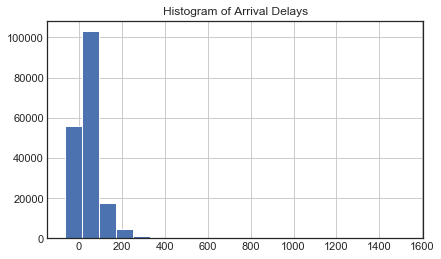

In [219]:
delay.ArrDelay.hist(bins=20)
plt.title('Histogram of Arrival Delays')
plt.show()

In [220]:
def Remove_Null_Columns(delay):
    dff = pd.DataFrame()
    for cl in fbinst:
        if delay[cl].isnull().sum() == len(delay[cl]):
            pass
        else:
            dff[cl] = delay[cl]
    return dff 

In [221]:
null_count = delay.isnull().sum()
null_count[null_count>0]

ArrTime              612
ActualElapsedTime    612
CRSElapsedTime        35
AirTime              612
ArrDelay             612
TaxiIn               612
dtype: int64

In [222]:
delay.dropna(how = 'all')

,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,Diverted,Day
0,1,3,4,2003,1955,2211,2225,128,150,116,-14,8,810,4,8,0,3
1,1,3,4,754,735,1002,1000,128,145,113,2,19,810,5,10,0,3
2,1,3,4,628,620,804,750,96,90,76,14,8,515,3,17,0,3
3,1,3,4,1829,1755,1959,1925,90,90,77,34,34,515,3,10,0,3
4,1,3,4,1940,1915,2121,2110,101,115,87,11,25,688,4,10,0,3
5,1,3,4,1937,1830,2037,1940,240,250,230,57,67,1591,3,7,0,3
6,1,3,4,706,700,916,915,130,135,106,1,6,828,5,19,0,3
7,1,3,4,1644,1510,1845,1725,121,135,107,80,94,828,6,8,0,3
8,1,3,4,1029,1020,1021,1010,52,50,37,11,9,162,6,9,0,3
9,1,3,4,1452,1425,1640,1625,228,240,213,15,27,1489,7,8,0,3


In [223]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn import tree
from IPython.display import Image
import pydotplus
import graphviz
%matplotlib inline

In [225]:
import numpy as np
from sklearn import linear_model
from sklearn.linear_model import SGDClassifier

In [ ]:



y = np.random.randn(n_samples)
X = np.random.randn(n_samples, n_features)
clf = linear_model.SGDRegressor(max_iter=1000, tol=1e-3)
clf.fit(X, y)